<a href="https://colab.research.google.com/github/Cksdud123/colab/blob/main/Anomaly_Detection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
import cv2
import numpy as np
from PIL import Image
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet101
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
import random
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.layers import Input,Flatten,Reshape,Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras.regularizers import l1
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error

In [23]:
# 정상 데이터
train_dir = glob.glob('/content/drive/MyDrive/Colab Notebooks/mvtec_anomaly_detection/bottle/train/good/*')
# 이상 데이터들
test_dir = glob.glob('/content/drive/MyDrive/Colab Notebooks/mvtec_anomaly_detection/bottle/test/broken_large/*')
test_dir_broken_small = glob.glob('/content/drive/MyDrive/Colab Notebooks/mvtec_anomaly_detection/bottle/test/broken_small/*')
test_dir_contamination = glob.glob('/content/drive/MyDrive/Colab Notebooks/mvtec_anomaly_detection/bottle/test/contamination/*')

In [24]:
train_images = []
test_images = []
target_size = (224, 224)

In [25]:
for img_path in train_dir:
    img = Image.open(img_path)
    rgb_img = img.convert('RGB')
    resized_img = rgb_img.resize(target_size)
    img_array = np.array(resized_img)
    min_value = img_array.min()
    max_value = img_array.max()
    normalized_img_array = (img_array - min_value) / (max_value - min_value)
    train_images.append(normalized_img_array)

for img_path in test_dir + test_dir_broken_small + test_dir_contamination:
    img = Image.open(img_path)
    rgb_img = img.convert('RGB')
    resized_img = rgb_img.resize(target_size)
    img_array = np.array(resized_img)  # 수정: img_array 대신 resized_img를 사용
    min_value = img_array.min()
    max_value = img_array.max()
    normalized_img_array = (img_array - min_value) / (max_value - min_value)
    test_images.append(normalized_img_array)

In [26]:
# 데이터 준비
train_images = np.array(train_images)
test_images = np.array(test_images)

In [27]:
# 랜덤 시드 설정
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [28]:
X_train,X_test = train_test_split(train_images, test_size=0.2, random_state=42)
X_train.shape

(167, 224, 224, 3)

In [11]:
# 인코더 모델 정의
input_layer = Input(shape=(224, 224, 3))  # 이미지의 크기와 채널 수 (224x224x3)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# 디코더 모델 정의
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_layer, decoded)

In [14]:
nb_epoch = 20
batch_size = 32
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1).history

Epoch 1/20
6/6 [==============================] - 4s 149ms/step - loss: 0.0177 - accuracy: 0.7314 - val_loss: 0.0271 - val_accuracy: 0.5308
Epoch 2/20
6/6 [==============================] - 0s 76ms/step - loss: 0.0146 - accuracy: 0.5957 - val_loss: 0.0076 - val_accuracy: 0.6225
Epoch 3/20
6/6 [==============================] - 0s 72ms/step - loss: 0.0103 - accuracy: 0.6169 - val_loss: 0.0103 - val_accuracy: 0.6286
Epoch 4/20
6/6 [==============================] - 0s 59ms/step - loss: 0.0073 - accuracy: 0.6420 - val_loss: 0.0042 - val_accuracy: 0.6752
Epoch 5/20
6/6 [==============================] - 0s 62ms/step - loss: 0.0043 - accuracy: 0.6861 - val_loss: 0.0031 - val_accuracy: 0.8094
Epoch 6/20
6/6 [==============================] - 0s 62ms/step - loss: 0.0023 - accuracy: 0.8230 - val_loss: 0.0025 - val_accuracy: 0.8343
Epoch 7/20
6/6 [==============================] - 0s 64ms/step - loss: 0.0024 - accuracy: 0.8179 - val_loss: 0.0019 - val_accuracy: 0.7648
Epoch 8/20
6/6 [==========

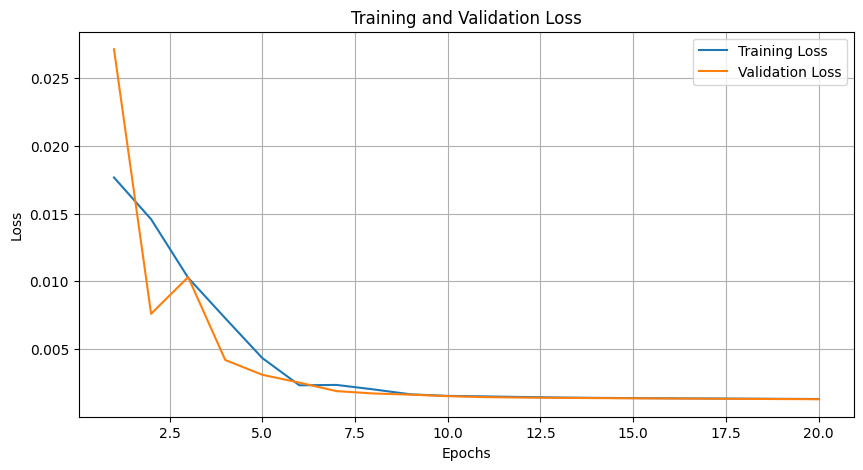

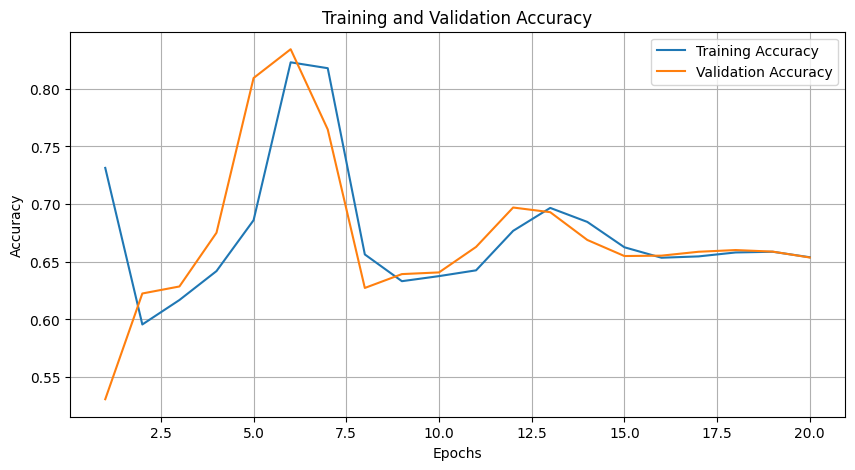

In [18]:
# 학습 결과를 기록한 history 객체에서 Loss와 Accuracy 추출
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

# Epoch 수
epochs = range(1, len(loss) + 1)

# Loss 그래프
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy 그래프
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

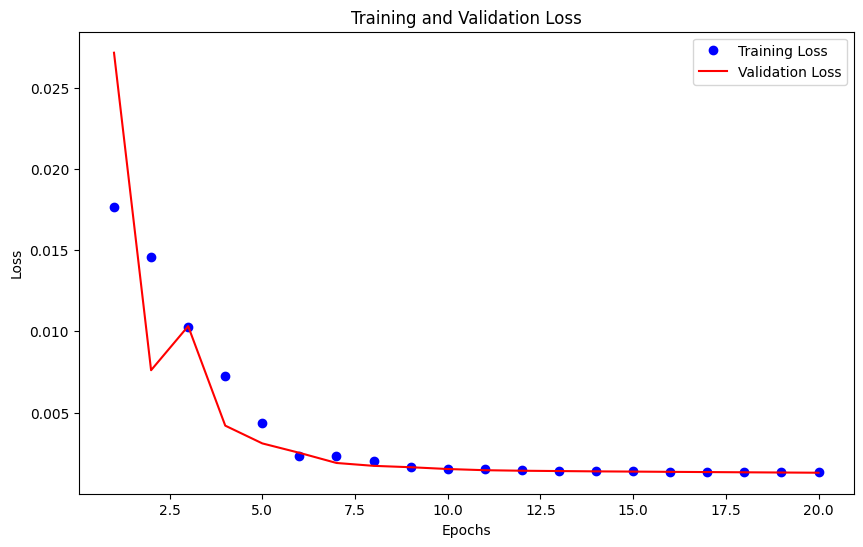

In [20]:
# 손실 함수 값 추출
loss = history['loss']
val_loss = history['val_loss']

# 그래프 그리기
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

6/6 [==============================] - 0s 21ms/step


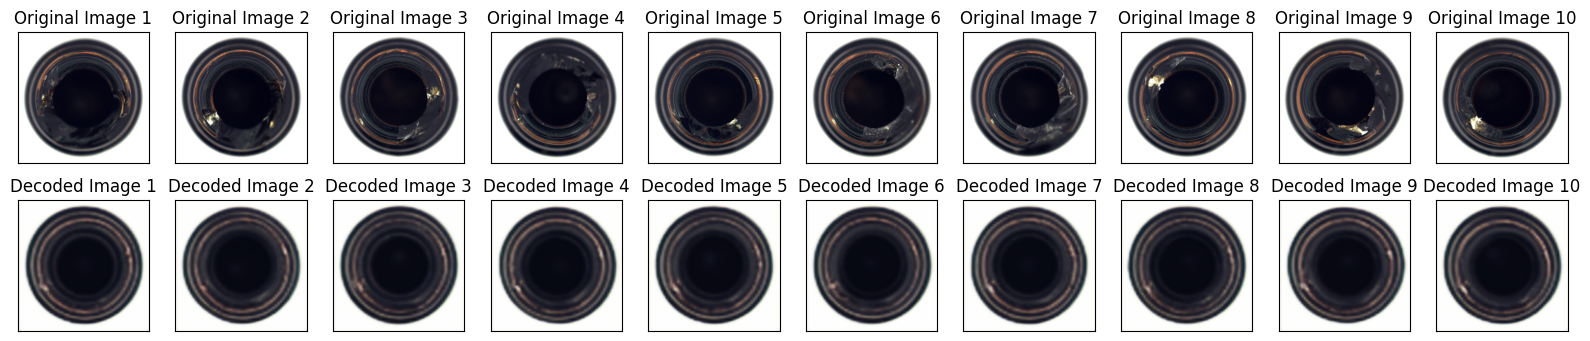

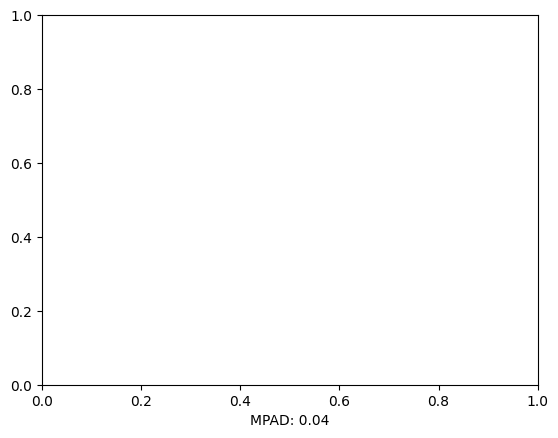

In [60]:
def mean_pixelwise_absolute_difference(image1, image2):
    abs_diff = np.abs(image1 - image2)
    mpad = np.mean(abs_diff)
    return mpad
# test_images 모델에 입력하여 재구성 이미지 생성
decoded_test_imgs = autoencoder.predict(X_train)

# 이미지 개수 설정
n = 10  # 시각화할 이미지 개수

# 원본 이미지와 재구성 이미지 비교 그래프
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 이미지
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].reshape(224, 224, 3))
    plt.title(f'Original Image {i+1}')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 재구성 이미지
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test_imgs[i].reshape(224, 224, 3))
    plt.title(f'Decoded Image {i+1}')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()
for i in range(n):
    # 일치율 계산
    mpad = mean_pixelwise_absolute_difference(test_images[i], decoded_test_imgs[i])
    plt.xlabel(f'MPAD: {mpad:.2f}')